# Implementation of Convolutional Encoder and Decoder for Bit-rate $\approx\frac{1}{2}$ with 2-PAM Modulation Scheme



The following implementation is done for Bit-Rate $\approx \frac{1}{2}$. The Convolutional Encoder is written for desired for any no.of Memory Units but The Convolutional Decoder, implemented using Viterbi's Algorithm is done for 2 Memory Units for simplicity.


## Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from skimage.color import rgb2gray
from PIL import Image
import math
from sklearn.metrics import mean_squared_error

## Binary Image

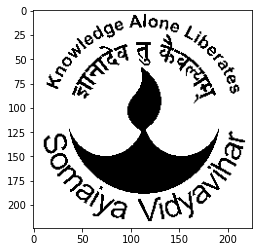

In [3]:
Data = np.load('./data/somaiya.npy') # .npy is a numpy array represeting the image in 0s and 1s
plt.imshow(Data,cmap='gray')

In [4]:
Data.shape

(224, 225)

In [5]:
Data.shape[0] * Data.shape[1]

50400

### Parameters

In [6]:
Variance = 10
N = 50
T = 1e-3
fc = 20000
mu = 2
n = 2

## Convolutional Encoder

Specification of Block Diagram:
1. No.of Input Bits = 1
2. No.of Outputs Bits($n$) = 2
3. No.of Memory Units($\mu$) = 2

So, for a $k$ input bits we will get
$N = n(k+\mu)$ output bits.

For $\mu = 2$,
Data stored in Memory Elements is none other than $x[n-1]$ and $x[n-2]$ respectively from left to right.




In [7]:
def ConvEncoder(BitStream,mu,n):
    k = BitStream.shape[0]
    TeriBits = np.zeros(mu,)
    U = np.zeros((mu,),dtype=int)
    OutputStream = np.zeros(((k+mu),2))

    Input = np.append(BitStream,TeriBits)

    for i in range(Input.shape[0]):
        a = U[0]
        b = U[1]
        c = int(Input[i])

        v1 = c ^ a                          # Setting parity equations
        v2 = c ^ a ^ b
        OutputStream[i] = np.array([v2,v1])
        
        U[0] = c
        U[1] = a

    return OutputStream

In [8]:
EncodedStream = ConvEncoder(Data.flatten(),mu,n)

## Modulation Scheme

Applying 2-PAM Modulation on Data Stream.

In [9]:
def PAM2Encoder(EncodedStream):
    S1 = np.where(EncodedStream == 1,EncodedStream, -1)
    return S1

In [10]:
ModulatedStream = PAM2Encoder(EncodedStream)

## Transmission

Transmitting Signal as $\sqrt2 cos(2\pi f_{c}t)$ and $-\sqrt2 cos(2\pi f_{c}t)$ for a span of $T$ seconds. Energy of Transmitted Signals are equal to $T$

In [11]:
def Transmission(ModulatedStream,T,fc,N):
    S = np.sqrt(2)*np.cos(2*np.pi*fc*np.linspace(0,T,N))
    l,m = ModulatedStream.shape
    n = S.shape[0]
    Output = np.zeros((l,m,n))

    for i in range(l):
        for j in range(m):
            Output[i][j] = ModulatedStream[i][j] * S

    return Output

In [12]:
TransmittedStream = Transmission(ModulatedStream,T,fc,N)

## Receiving Data

AWGN (Additive White Gaussian Noise) is added to Transmitted Signals

In [13]:
def ReceivingData(TransmittedStream,Variance):
    l,m,n = TransmittedStream.shape
    Output = np.zeros(TransmittedStream.shape)
    for i in range(l):
        for j in range(m):
            Output[i][j] = TransmittedStream[i][j] + np.random.normal(0,np.sqrt(Variance),size=n)

    return Output

In [14]:
ReceivedStream = ReceivingData(TransmittedStream,Variance)

## DeModulation

Obtained Waveforms are DeModulated.

In [15]:
def PAM2Waveforms(T,N,fc):
    Waveforms = np.zeros((2,N))

    Waveforms[0] = -np.sqrt(2)*np.cos(2*np.pi*fc*np.linspace(0,T,N))
    Waveforms[1] = np.sqrt(2)*np.cos(2*np.pi*fc*np.linspace(0,T,N))

    return Waveforms

Waveforms = PAM2Waveforms(T,N,fc)

In [16]:
def DeModulation(ReceivedStream,Waveforms):

    Output = np.zeros((ReceivedStream.shape[0],ReceivedStream.shape[1]))

    for i in range(ReceivedStream.shape[0]):
        for j in range(ReceivedStream.shape[1]):
            Output[i][j] = np.argmin(np.sum(np.multiply((ReceivedStream[i][j] - Waveforms),(ReceivedStream[i][j] - Waveforms)),axis=1))

    return Output           

In [17]:
DeModulatedStream = DeModulation(ReceivedStream,Waveforms)

Error between Demodulated Stream and Encoded Stream

In [32]:
error_bits_before = np.sum(np.abs(DeModulatedStream-EncodedStream))
error_bits_before

1168.0

## Viterbi Decoding for $\mu = 2$

In [19]:
def HammingDistance(a,b):
    return np.sum(np.square(a-b))

In [20]:
def ViterbiDecoder(DeModulatedStream,mu):
    # Look-up Table for State Machine
    # MIT's State Table
    State_Table = [
            [0, 0, [0,0], 0],
            [0, 0, [1,0], 1],
            [1, 0, [1,1], 2],
            [1, 0, [0,1], 3],
            [2, 1, [1,1], 0],
            [2, 1, [0,1], 1],
            [3, 1, [0,0], 2],
            [3, 1, [1,0], 3]
    ]

    m = DeModulatedStream.shape[0]
    k = pow(2,mu)

    
    Path_Metric = np.zeros((k,m+1))
    Path_Metric[1:4,0] = 1e6 * np.ones((3,))

    # Creating Path Metrics.
    for i in range(1,m+1): # for each received input
        for j in range(k): # for each state
            BM1 = HammingDistance(DeModulatedStream[i-1],State_Table[2*j][2])    # Branch metric from Alpha to current state 
            BM2 = HammingDistance(DeModulatedStream[i-1],State_Table[2*j + 1][2]) # Branch metric from Beta to current state
            V1 = Path_Metric[State_Table[2*j][3]][i-1] + BM1 #(PM + BM) for Alpha
            V2 = Path_Metric[State_Table[2*j + 1][3]][i-1] + BM2 #(PM + BM) for Beta
            
            Path_Metric[j][i] = min(V1,V2)
    
    Output = []
    
    ind = np.argmin(Path_Metric[:,i])    
    for i in reversed(range(1,m+1)):    # reversing the received input
        a = State_Table[2*ind][3]
        b = State_Table[2*ind + 1][3]
        if (Path_Metric[:,i-1][a] <= Path_Metric[:,i-1][b]):    # comparing the path metrics for different states to get the smallest path
            ind_prev = a
        else:
            ind_prev = b
            
        for j in range(len(State_Table)):
            if (State_Table[j][0] == ind and State_Table[j][3] == ind_prev):
                Output.append(State_Table[j][1])
        ind = ind_prev
                
    Output.reverse()        # Reversing the result to get the final output back 
    
    Output.pop()
    Output.pop()
    return np.array(Output)

In [21]:
DecodedStream = ViterbiDecoder(DeModulatedStream,mu)

Calculating Error Bits and Percentage

In [34]:
ErrorBitsFinal = np.sum(np.abs(DecodedStream - Data.flatten()))
ErrorBitsFinal

126

In [35]:
print("Error bits before Viterbi:" + str(error_bits_before))
print("Number of Error bits after Viterbi:" + str(ErrorBitsFinal))

Error bits before Viterbi:1168.0
Number of Error bits after Viterbi:126


In [36]:
Percentage = (1 - ErrorBitsFinal/DecodedStream.shape[0]) * 100
Percentage

99.75

## Image

Image from Decoded Data

In [37]:
OutputImage = np.reshape(DecodedStream,Data.shape)

Text(0.5, 1.0, 'Decoded Output')

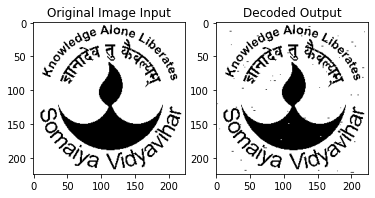

In [38]:
f, axarr = plt.subplots(1,2)

axarr[0].imshow(Data,cmap='gray')
axarr[0].set_title('Original Image Input')
axarr[1].imshow(OutputImage,'gray')
axarr[1].set_title('Decoded Output')